In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division
import six

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)

from pynrc import speckle_noise as sn

import astropy.io.fits as fits
import astropy.io.ascii as ascii
import multiprocessing as mp

import scipy

In [3]:
pynrc.setup_logging('WARNING', verbose=False)

In [4]:
data_path = webbpsf.utils.get_webbpsf_data_path() + '/'
opd_path = data_path + 'NIRCam/OPD/'
opd_file = 'OPD_RevV_nircam_132.fits'
opds, header = fits.getdata(opd_path + opd_file, header=True)

In [5]:
nopd = opds.shape[0]
nproc = int(np.min([nopd,mp.cpu_count()*0.75]))

In [6]:
# Multiprocessing or each OPD
%time opds_all = sn.opd_extract_mp(opds, header)

Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
CPU times: user 1.62 s, sys: 3.49 s, total: 5.11 s
Wall time: 54.2 s


[ 0.          0.          0.          0.03361531  0.02086653  0.02146281
  0.02511235  0.02364838  0.01719577  0.00775705  0.02014983  0.01799566
  0.01361106  0.01536014  0.00972684]


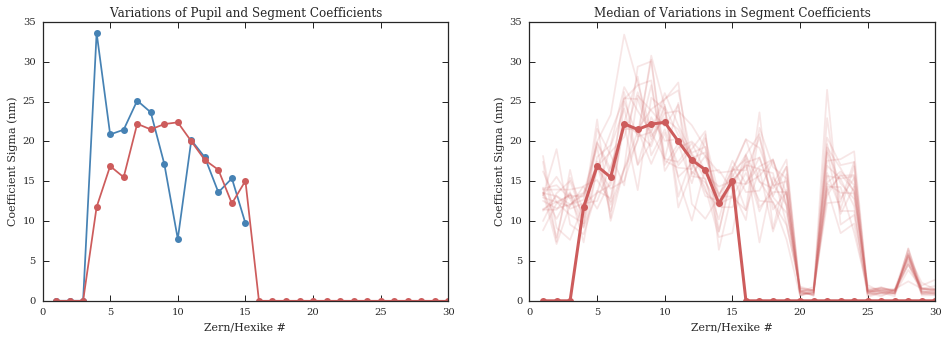

In [7]:
# For the pupil OPD and each segment OPD, find the stdev of each Zern/Hexike coefficient
pup_cf_std = np.array([opds_all[i].coeff_pupil for i in range(9)]).std(axis=0)

nseg = 18
seg_cf_std_all = []
for j in range(nseg):
    std = np.array([opds_all[i].coeff_segs[j] for i in range(9)]).std(axis=0)
    seg_cf_std_all.append(std)
seg_cf_std = np.median(seg_cf_std_all, axis=0)

# These values will be used to vary RMS WFE
# Set the piston values (Z1) to 0
# John Krist also says tip/tilt (Z2-3) are 0
pup_cf_std[0:3] = 0.0
seg_cf_std[0:3] = 0.0

# Zern/Hexikes to vary: Z = 3-14 (indices 3-7)
pup_cf_std[15:] = 0
seg_cf_std[15:] = 0

znum_pup = np.arange(len(pup_cf_std))+1
znum_seg = np.arange(len(seg_cf_std))+1

f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(znum_pup, pup_cf_std*1000, color='steelblue', marker='o')
ax1.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o')
ax1.set_title('Variations of Pupil and Segment Coefficients')
ax2.set_title('Median of Variations in Segment Coefficients')

for seg in seg_cf_std_all: 
    ax2.plot(znum_seg, seg*1000, color='indianred', alpha=0.15)
ax2.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o', lw=3)

for ax in (ax1,ax2):
    ax.set_xlabel('Zern/Hexike #')
    ax.set_ylabel('Coefficient Sigma (nm)')
    
print(pup_cf_std)

## Science and Reference OPDs

In [8]:
# Generate list of science OPDs and residuals for use in reference drift.
%time opd_sci_list, opd_resid_list = sn.opd_sci_gen_mp(opds_all)

CPU times: user 2.39 s, sys: 3.64 s, total: 6.03 s
Wall time: 12.8 s


In [9]:
# Reference OPDS for 10nm WFE drift
wfe_drift = 10.0
# Arguments to pass
args = (opds_all, pup_cf_std, seg_cf_std, opd_resid_list) 
%time opd_ref_list = sn.ODP_drift_all(wfe_drift, *args)

Finished: 10 nm
CPU times: user 2.51 s, sys: 4.17 s, total: 6.68 s
Wall time: 16.6 s


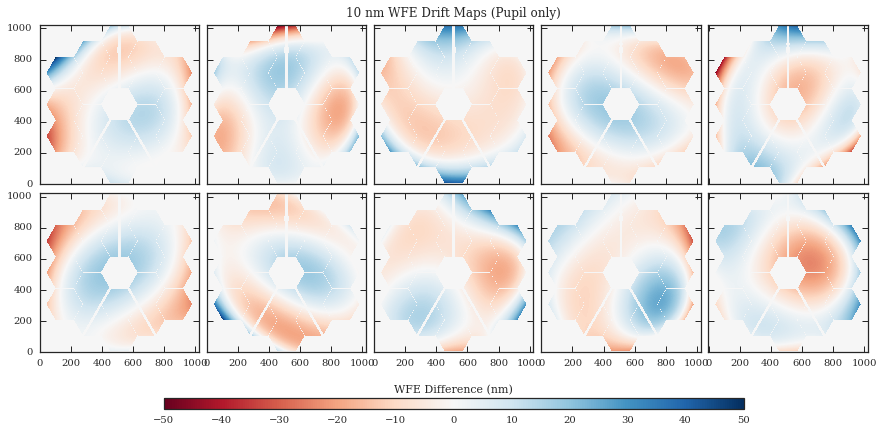

In [10]:
vlim = 5*wfe_drift

fig, axes = plt.subplots(2,5,figsize=(11.5,6))
for i,ax in enumerate(axes.flat):
    im = ax.imshow((opd_sci_list[i]-opd_ref_list[i])*1000, cmap='RdBu', vmin=-vlim, vmax=vlim)
    ax.set_aspect('equal')
    if i % 5 > 0: ax.set_yticklabels([])
    if i < 5: ax.set_xticklabels([])

#fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.94, bottom=0.18, left=0, right=1)

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.025])
fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal')
cbar_ax.set_xlabel('WFE Difference (nm)')
cbar_ax.xaxis.set_label_position('top');

fig.suptitle('{:.0f} nm WFE Drift Maps (Pupil only)'.format(wfe_drift));
#outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+'wfe_diff_10nm_lebreton.pdf')

## Science and Reference Observations

In [230]:
#filt, mask, pupil = ('F200W', 'MASK210R', 'CIRCLYOT')
#fov_pix = 320
#
#hdu = fits.PrimaryHDU(opd_sci_list[0])
#hdu.header = header.copy()
#opd_hdulist = fits.HDUList([hdu])    
#sci = pynrc.NIRCam(filt, pupil, mask, save_psf=True, force=True, opd=opd_hdulist, fov_pix=fov_pix)
#
#hdu = fits.PrimaryHDU(opd_ref_list[0])
#hdu.header = header.copy()
#opd_hdulist = fits.HDUList([hdu])    
#ref = pynrc.NIRCam(filt, pupil, mask, save_psf=True, force=True, opd=opd_hdulist, fov_pix=fov_pix)

In [217]:
def calc_contrast(psf0, psf1, psf2, sci, ref):
    from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
    from scipy.ndimage.interpolation import rotate

    # Add noise to psf1 and psf2
    det = sci.Detectors[0]
    fzodi = sci.bg_zodi()
    im_noise = det.pixel_noise(fsrc=psf1, fzodi=fzodi)
    
    # Roll 1 and 2 simulated slope images
    im_roll1 = psf1 + np.random.normal(scale=im_noise)
    im_roll2 = psf1 + np.random.normal(scale=im_noise)
    
    # Add noise to psf1 and psf2
    det = ref.Detectors[0]
    fzodi = ref.bg_zodi()
    im_noise = det.pixel_noise(fsrc=psf2, fzodi=fzodi)
    
    # Reference simulated slope image
    im_ref = psf2 + np.random.normal(scale=im_noise)
    
    # Detector-sampled difference
    scale1 = im_roll1.sum() / im_ref.sum()
    scale2 = im_roll2.sum() / im_ref.sum()
    im_diff1 = im_roll1 - im_ref*scale1
    im_diff2 = im_roll2 - im_ref*scale2
    im_diff2_rot = rotate(im_diff2, 10, reshape=False)
    final = (im_diff1 + im_diff2_rot) / 2

    hdu = fits.PrimaryHDU(final)
    hdu.header['EXTNAME'] = ('DET_SAMP')
    hdu.header['OVERSAMP'] = 1
    hdu.header['PIXELSCL'] = sci.pix_scale / hdu.header['OVERSAMP']
    hdu_diff = fits.HDUList([hdu])
    
    # Radial noise
    binsize = hdu_diff[0].header['OVERSAMP'] * hdu_diff[0].header['PIXELSCL']
    rr, stds = webbpsf.radial_profile(hdu_diff, ext=0, stddev=True, binsize=binsize)
    stds = convolve(stds, Gaussian1DKernel(1))

    # Ignore corner regions
    xsize = hdu_diff[0].header['PIXELSCL'] * hdu_diff[0].data.shape[0] / 2
    mask = rr<xsize
    rr = rr[mask]
    stds = stds[mask]
    
    contrast = stds / psf0.max()
        
    return rr, contrast

## Spectral Type Mismatching

In [219]:
# Make a list of spectrum to compare to each other
lookuptable = {
    "A0V": (9500, 0.0, 4.0),
    "A1V": (9250, 0.0, 4.0),
    "A3V": (8270, 0.0, 4.0),
    "A5V": (8200, 0.0, 4.0),
    "F0V": (7250, 0.0, 4.0),
    "F2V": (7000, 0.0, 4.0),
    "F5V": (6500, 0.0, 4.0),
    "F8V": (6250, 0.0, 4.5),
    "G0V": (6000, 0.0, 4.5),
    "G2V": (5850, 0.0, 4.5),
    "G5V": (5750, 0.0, 4.5),
    "G8V": (5500, 0.0, 4.5),
    "K0V": (5250, 0.0, 4.5),
    "K2V": (4500, 0.0, 4.5),
    "K5V": (4250, 0.0, 4.5),
    "K7V": (4000, 0.0, 4.5),
    "M0V": (3750, 0.0, 4.5),
    "M2V": (3500, 0.0, 4.5),
    "M5V": (3500, 0.0, 5.0),
    "G0III": (5750, 0.0, 3.0),
    "G5III": (5250, 0.0, 2.5),
    "K0III": (4750, 0.0, 2.0),
    "K5III": (4000, 0.0, 1.5),
    "M0III": (3750, 0.0, 1.5)}

# For sorting of spectral types from early to late type
def sort_sptype(typestr):
    letter = typestr[0]
    lettervals = {'O': 0, 'B': 1, 'A': 2, 'F': 3, 'G': 4, 'K': 5, 'M': 6}
    value = lettervals[letter] * 1.0
    value += (int(typestr[1]) * 0.1)
    if "III" in typestr:
        value += 50
    elif "I" in typestr:
        value += 70
    elif "V" in typestr:
        value += 30
    return value

sptype_list = list(lookuptable.keys())
sptype_list.sort(key=sort_sptype)

In [463]:
def do_sptype_mismatch(mag_bp=0):
    # Generate spectra for spectal types
    sp_list = []
    #mag_bp = 0 # Stellar magnitude in NIRCam bandpass
    for sptype in sptype_list:
        v0,v1,v2 = lookuptable[sptype]
        sp = S.Icat('ck04models', v0, v1, v2)
        sp = sp.renorm(mag_bp, 'vegamag', sci.bandpass)
        sp.name = sptype
        sp_list.append(sp)

    nspec = len(sp_list)
    
    # For each spectral type, make a psf0, psf1, and psf2
    # psf0 is the unocculted planet image for contrast calculations
    # psf1 is the occulted science target star
    # psf2 is the occulted reference star
    psf2_list = []
    # Only need to create psf2 once for each spectrum
    for sp in sp_list:
        psf2 = ref.gen_psf(sp, return_oversample=False)
        psf2_list.append(psf2)
        
    # Get contrast for each spectral type pairing
    contrast_arr_list = []
    for i, sp in enumerate(sp_list):
        #print(sp.name)
        psf0 = sci.gen_psf(sp, return_oversample=False, use_bg_psf=True)
        psf1 = sci.gen_psf(sp, return_oversample=False)
        
        contrast_list = []
        for psf2 in psf2_list:
            rr, contrast = calc_contrast(psf0, psf1, psf2, sci, ref)
            contrast_list.append(contrast)
        contrast_arr = np.array(contrast_list)
        contrast_arr_list.append(contrast_arr)
        
    # All the contrasts in an array
    contrast_all = np.array(contrast_arr_list)

    # We really only care about how much magnitude contrast
    # is lost when moving away from perfect spectral type match
    contrast_scale = np.zeros([nspec,nspec])
    mag_diff = np.zeros([nspec,nspec])
    for i in range(nspec):
        contrast_same_teff = contrast_all[i,i,:]
        for j in range(nspec):
            contrast = contrast_all[i,j,:]
            scale = contrast / contrast_same_teff
            scale = scale[(rr>0.5) & (rr<2)]
            scale_med = np.median(scale)
            if scale_med<1: scale_med=1
            contrast_scale[i,j] = scale_med
            mag_diff[i,j] = 2.5*np.log10(scale_med)
            
    # Plot the grid of data as a heat map
    fig, ax = plt.subplots(figsize=(12,6))
    hmap = mag_diff[:19,:]
    sns.heatmap(hmap[::-1,:], ax=ax, vmin=0, vmax=1, cbar_kws={'label':'Magnitude Loss'},
                annot=True, fmt='.2f', annot_kws={'fontsize':8}, cmap=cmap)
    ax.set_xlabel('Reference Star SpType', fontsize=12)
    ax.set_ylabel('Science Target SpType', fontsize=12)
    ax.set_title('Average Sensitivity Loss at $r=0.5-2^{{\prime\prime}}$  ({}+{})'\
                 .format(sci.filter, sci.mask), fontsize=14)
    ax.set_yticklabels(sptype_list[:19], rotation=0)
    ax.set_xticklabels(sptype_list, rotation=45)

    fig.tight_layout()
    #fig.savefig('references_{}_{}_sptype.pdf'.format(sci.filter,sci.mask))
    
    if pp is not None: pp.savefig(figure=fig)

## Photon Flux Difference

In [469]:
def do_photon_flux(pp_mag=None, pp_gam=None, cmap_mag=None, cmap_gam=None):
    # Some fiducial 0 mag spectrum
    sp = nrc_utils.stellar_spectrum('flat', 0, 'vegamag', sci.bandpass)

    # Noiseless slope images
    #  - psf0 is the unocculted planet image for contrast calculations
    #  - psf1 is the occulted science target star
    #  - psf2 is the occulted reference star
    psf0 = sci.gen_psf(sp, return_oversample=False, use_bg_psf=True)
    psf1 = sci.gen_psf(sp, return_oversample=False)
    psf2 = ref.gen_psf(sp, return_oversample=False)
    
    # Science target
    mag_vals = np.arange(0,12.5,0.5)
    psf_scale = 10**(-mag_vals / 2.5)
    nmag = len(mag_vals)
    
    
    # Calculate contrasts
    contrast_arr_list = []
    for i, scale1 in enumerate(psf_scale):
        #print(mag_vals[i])
        psf0_temp = psf0*scale1
        psf1_temp = psf1*scale1

        contrast_list = []
        for scale2 in psf_scale:
            psf2_temp = psf2*scale2
            rr, contrast = calc_contrast(psf0_temp, psf1_temp, psf2_temp, sci, ref)
            contrast_list.append(contrast)

        contrast_arr = np.array(contrast_list)
        contrast_arr_list.append(contrast_arr)

    # All the contrasts in an array
    contrast_all = np.array(contrast_arr_list)

    # We really only care about how much magnitude contrast
    # we lose when moving away from perfect spectral type match
    contrast_scale = np.zeros([nmag,nmag])
    mag_diff = np.zeros([nmag,nmag])
    for i in range(nmag):
        contrast_same_teff = contrast_all[i,0,:]
        for j in range(nmag):
            contrast = contrast_all[i,j,:]
            scale = contrast / contrast_same_teff
            scale = scale[(rr>4) & (rr<5)]
            scale_med = np.median(scale)
            if scale_med<1: scale_med=1
            contrast_scale[i,j] = scale_med
            mag_diff[i,j] = 2.5*np.log10(scale_med)
            
    # Plot the grid of data as a heat map
    fig, ax = plt.subplots(figsize=(12,6))
    hmap = mag_diff[:,:17]
    #cmap = sns.cubehelix_palette(10, light=0.95, rot=-0.4, as_cmap=True)
    sns.heatmap(hmap[:,::-1].T, ax=ax, vmin=0, vmax=1, cbar_kws={'label':'Magnitude Loss'},
                annot=True, fmt='.2f', annot_kws={'fontsize':8}, cmap=cmap_mag)
    ax.set_ylabel('Reference Star Magnitude', fontsize=12)
    ax.set_xlabel('Science Target Magnitude', fontsize=12)
    ax.set_title('Average Sensitivity Loss at $r=4-5^{{\prime\prime}}$  ({}+{})'\
                 .format(sci.filter, sci.mask), fontsize=14)
    ax.set_yticklabels(mag_vals[:17], rotation=0)
    ax.set_xticklabels(mag_vals, rotation=45)

    fig.tight_layout()
    #fig.savefig('references_{}_{}_magnitudes.pdf'.format(sci.filter,sci.mask))
    if pp_mag is not None: pp_mag.savefig(figure=fig)
        
    ######################
    ### Same as above, but in terms of gamma = (sci tot counts) / (ref tot counts)
    ######################
    gamma_vals = np.array([0.1,0.2,0.5] + range(1,11,1))
    ngam = len(gamma_vals)

    # Calculate contrasts
    contrast_arr_list = []
    for i, scale1 in enumerate(psf_scale):
        #print(mag_vals[i])
        psf0_temp = psf0*scale1
        psf1_temp = psf1*scale1

        contrast_list = []
        for gamma in gamma_vals:
            scale2 = 2*scale1 / gamma
            psf2_temp = psf2*scale2
            rr, contrast = calc_contrast(psf0_temp, psf1_temp, psf2_temp, sci, ref)
            contrast_list.append(contrast)

        contrast_arr = np.array(contrast_list)
        contrast_arr_list.append(contrast_arr)

    # All the contrasts in an array
    contrast_gamma_all = np.array(contrast_arr_list)

    # We really only care about how much magnitude contrast
    # we lose when moving away from perfect spectral type match
    contrast_scale = np.zeros([nmag,ngam])
    mag_diff = np.zeros([nmag,ngam])
    for i in range(nmag):
        contrast_same_teff = contrast_gamma_all[i,0,:]
        for j in range(ngam):
            contrast = contrast_gamma_all[i,j,:]
            scale = contrast / contrast_same_teff
            scale = scale[(rr>4) & (rr<5)]
            scale_med = np.median(scale)
            #if scale_med<1: scale_med=1
            contrast_scale[i,j] = scale_med
            mag_diff[i,j] = 2.5*np.log10(scale_med)
            
    # Plot the grid of data as a heat map
    fig, ax = plt.subplots(figsize=(12,6))
    hmap = mag_diff
    #cmap = sns.cubehelix_palette(10, light=0.95, start=2.8, rot=0.1, as_cmap=True)
    sns.heatmap(hmap[:,::-1].T, ax=ax, vmin=0, vmax=1.0, cbar_kws={'label':'Magnitude Loss'},
                annot=True, fmt='.2f', annot_kws={'fontsize':8}, cmap=cmap_gam)
    ax.set_ylabel('Gamma (Science/Reference counts)', fontsize=12)
    ax.set_xlabel('Science Target Magnitude', fontsize=12)
    ax.set_title('Average Sensitivity Loss at $r=4-5^{{\prime\prime}}$  ({}+{})'\
                 .format(sci.filter, sci.mask), fontsize=14)
    ax.set_yticklabels(gamma_vals, rotation=0)
    ax.set_xticklabels(mag_vals, rotation=45)

    fig.tight_layout()
    #fig.savefig('references_{}_{}_gamma.pdf'.format(sci.filter,sci.mask))
    if pp_gam is not None: pp_gam.savefig(figure=fig)

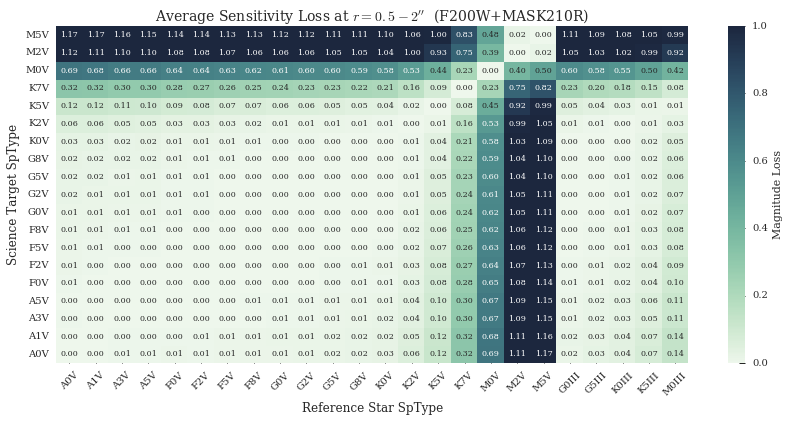

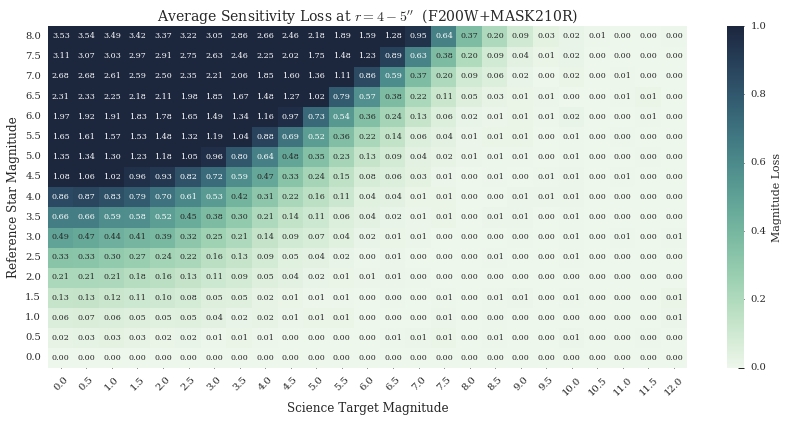

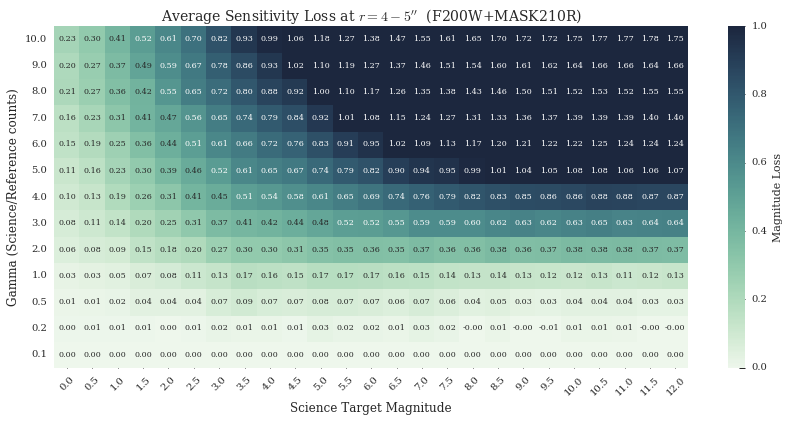

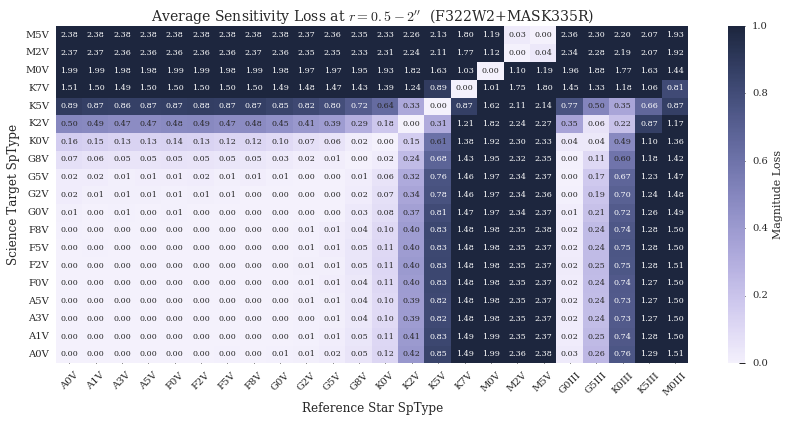

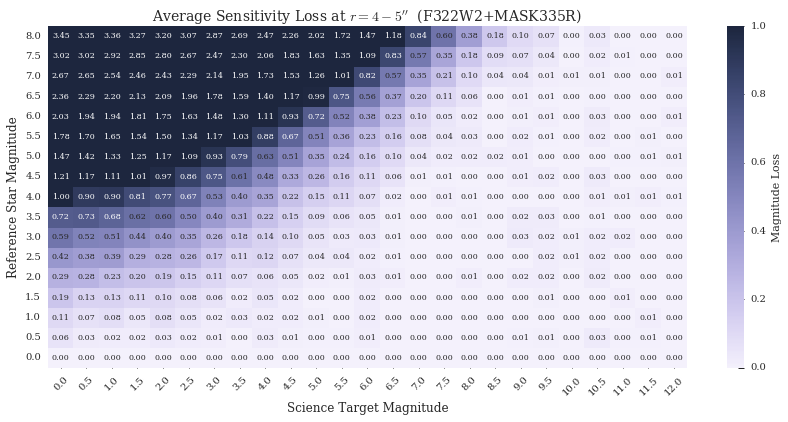

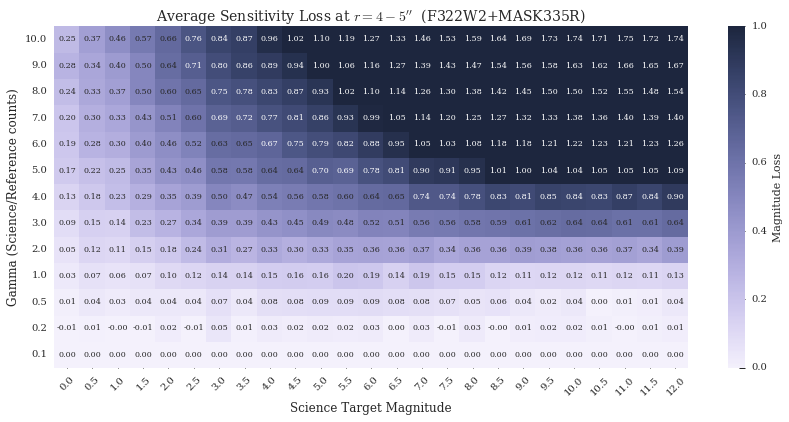

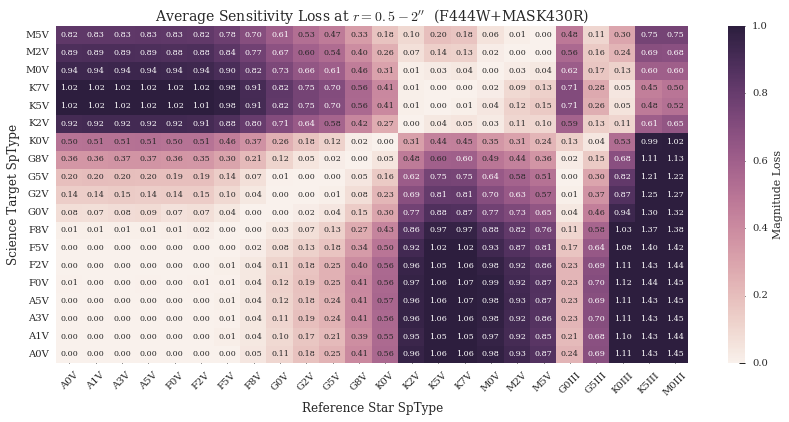

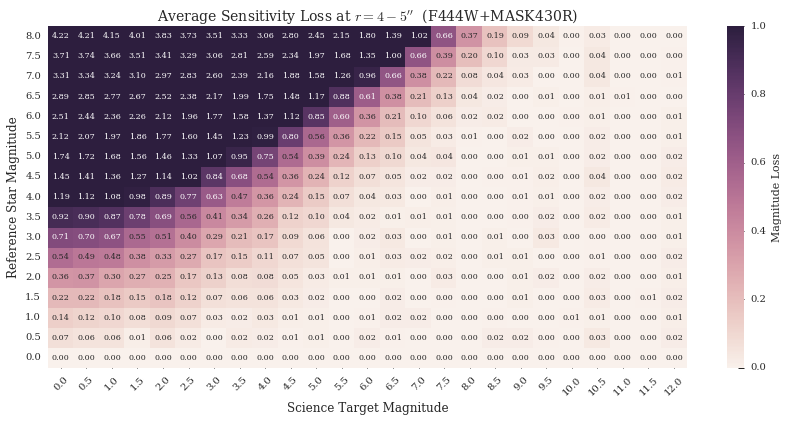

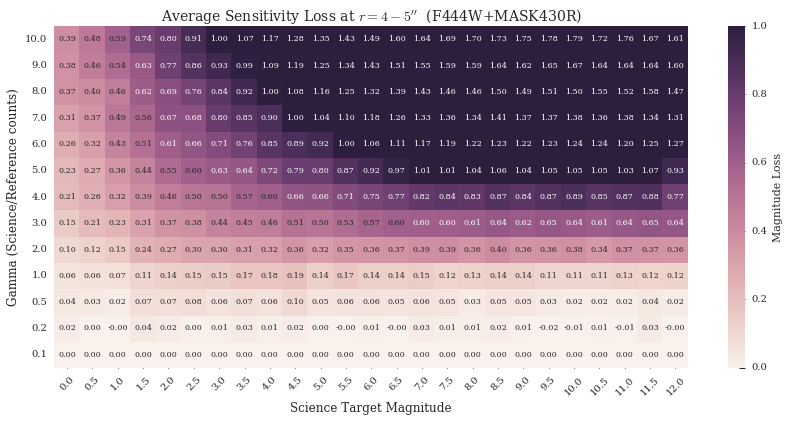

In [470]:
cmap2 = sns.cubehelix_palette(10, light=0.95, start=2.8, rot=0.1, as_cmap=True)
cmap3 = sns.cubehelix_palette(10, light=0.95, rot=-0.4, as_cmap=True)
cmap_list = [cmap3,cmap2,None]

obs_params = [('F200W',  'MASK210R', 'CIRCLYOT'), 
              ('F322W2', 'MASK335R', 'CIRCLYOT'),
              ('F444W',  'MASK430R', 'CIRCLYOT')]

pp_sptype = PdfPages('references_sptype.pdf')
pp_mag = PdfPages('references_magnitudes.pdf')
pp_gam = PdfPages('references_gamma.pdf')
for i, op in enumerate(obs_params):
    filt, mask, pupil = op
    fov_pix = 320 if '210R' in mask else 160
    
    hdu = fits.PrimaryHDU(opd_sci_list[0])
    hdu.header = header.copy()
    opd_hdulist = fits.HDUList([hdu])    
    sci = pynrc.NIRCam(filt, pupil, mask, save_psf=True, force=True, opd=opd_hdulist, fov_pix=fov_pix)

    hdu = fits.PrimaryHDU(opd_ref_list[0])
    hdu.header = header.copy()
    opd_hdulist = fits.HDUList([hdu])    
    ref = pynrc.NIRCam(filt, pupil, mask, save_psf=True, force=True, opd=opd_hdulist, fov_pix=fov_pix)

    sci.update_detectors(wind_mode='WINDOW', xpix=320, ypix=320, read_mode='DEEP8', ngroup=10, nint=5)
    ref.update_detectors(wind_mode='WINDOW', xpix=320, ypix=320, read_mode='DEEP8', ngroup=10, nint=5)

    cmap = cmap_list[i]
    do_sptype_mismatch(pp=pp_sptype, cmap=cmap)
    do_photon_flux(pp_mag, pp_gam, cmap, cmap)
    
pp_sptype.close()
pp_mag.close()
pp_gam.close()
clear_output()

In [506]:
def bin_spectrum(sp, wave, waveunits='um'):
    """
    Rebin a Pysynphot spectrum to a lower wavelenght grid.
    This function first converts the input spectrum to units
    of photlam then combines the photon flux onto the 
    desired wavelength bin
    
    Output spectrum units are the same as the input spectrum.
    """

    waveunits0 = sp.waveunits
    fluxunits0 = sp.fluxunits

    sp.convert(waveunits)
    sp.convert('photlam')

    edges = S.binning.calculate_bin_edges(wave)
    indices = np.searchsorted(sp.wave, edges)
    i1_arr = indices[:-1]
    i2_arr = indices[1:]

    # This assumes the original wavelength grid is uniform
    binflux = np.empty(shape=wave.shape, dtype=np.float64)
    for i in range(len(wave)):
        i1 = i1_arr[i]
        i2 = i2_arr[i]
        binflux[i] = sp.flux[i1:i2].sum() / (i2-i1)
    
    sp2 = S.ArraySpectrum(wave, binflux, waveunits=waveunits, fluxunits='photlam')
    sp2.convert(waveunits0)
    sp2.convert(fluxunits0)
    sp.convert(waveunits0)
    sp.convert(fluxunits0)

    return sp2

# eps Eri Example

In [543]:
# Reference star names and settings
# Name, Sp Type, Kmag, distance, extra INT
refs = [('HD 21019', (5465, -0.45, 3.9),   4.42, 2.9, 1),
        ('BR Eri',    'M5III',   0.92, 4.6, 1), 
        ('HD 22409', (5000, -0.25, 2.7), 3.66, 1.9, 0),
        ('HD 21419', 'K1III', 4.80, 2.1, 0),
        ('HR 1050',  'K2III', 3.24, 2.2, 0),
        ('HD 21571', (5636, -0.30, 4.36), 3.54, 3.9, 1),
        ('HD 20356', 'K4III', 2.31, 5.5, 0),
        ('HD 22242', 'K4III', 4.81, 2.1, 0),
        ('HD 22807', 'K5III', 4.47, 2.3, 0), 
        ('del Eri',  (5055, 0.13, 3.9), 1.43, 2.6, 1),
        ('HD 24338', 'M2III', 2.98, 5.3, 0),
        ('Ideal',    (5084, -0.13, 4.3), 0.00, 0.0, 0)]


# Sort by distance
refs.sort(key=lambda tup: tup[3])

In [544]:
names = [tup[0] for tup in refs]
names

['Ideal',
 'HD 22409',
 'HD 21419',
 'HD 22242',
 'HR 1050',
 'HD 22807',
 'del Eri',
 'HD 21019',
 'HD 21571',
 'BR Eri',
 'HD 24338',
 'HD 20356']

In [545]:
obs_params = [('F200W',  'MASK210R', 'CIRCLYOT'), 
              ('F322W2', 'MASK335R', 'CIRCLYOT'),
              ('F444W',  'MASK430R', 'CIRCLYOT')]

nint_sci_dict = {'F200W': 8, 'F322W2':3, 'F444W':5}
nint_ref_dict = {'F200W':14, 'F322W2':6, 'F444W':8}

contrast_eps_all = []
rr_all = []
for filt, mask, pupil in obs_params:
    
    print(filt, mask, pupil)
    fov_pix = 320 if '210R' in mask else 160
    
    hdu = fits.PrimaryHDU(opd_sci_list[0])
    hdu.header = header.copy()
    opd_hdulist = fits.HDUList([hdu])    
    sci = pynrc.NIRCam(filt, pupil, mask, save_psf=True, force=True, opd=opd_hdulist, fov_pix=fov_pix)
    
    hdu = fits.PrimaryHDU(opd_ref_list[0])
    hdu.header = header.copy()
    opd_hdulist = fits.HDUList([hdu])    
    ref = pynrc.NIRCam(filt, pupil, mask, save_psf=True, force=True, opd=opd_hdulist, fov_pix=fov_pix)

    bp_k = S.ObsBandpass('k')
    #sp_sci = nrc_utils.stellar_spectrum('K2V', 1.67, 'vegamag', bp_k, catname='ck04models')
    sp = S.Icat('ck04models', 5084, -0.13, 4.3)
    sp_sci = sp.renorm(1.67, 'vegamag', bp_k)

    # Noiseless slope images
    #  - psf0 is the unocculted planet image for contrast calculations
    #  - psf1 is the occulted science target star
    #  - psf2 is the occulted reference star
    psf0 = sci.gen_psf(sp_sci, return_oversample=False, use_bg_psf=True)
    psf1 = sci.gen_psf(sp_sci, return_oversample=False)
    
    contrast_list = []
    print('Calculating Contrast Curves...')
    for vals in refs:
        v0, v1, v2, v3, v4 = vals
        
        nint_sci = nint_sci_dict.get(filt, 9)
        nint_ref = nint_ref_dict.get(filt, 9)
        sci.update_detectors(wind_mode='WINDOW', xpix=320, ypix=320, read_mode='DEEP8', ngroup=10, nint=nint_sci)
        ref.update_detectors(wind_mode='WINDOW', xpix=320, ypix=320, read_mode='DEEP8', ngroup=10, nint=nint_ref+v4)

        if isinstance(v1, six.string_types):
            sp_ref = nrc_utils.stellar_spectrum(v1, v2, 'vegamag', bp_k, catname='ck04models')
        else:
            sp = S.Icat('ck04models', *v1)
            sp_ref = sp.renorm(v2, 'vegamag', bp_k)

        psf2 = ref.gen_psf(sp_ref, return_oversample=False)
        rr, contrast = calc_contrast(psf0, psf1, psf2, sci, ref)
        contrast_list.append(contrast)
        
    contrast_eps_all.append(contrast_list)
    rr_all.append(rr)
    print('Finished.\n')

F200W MASK210R CIRCLYOT
Calculating Contrast Curves...
Finished.

F322W2 MASK335R CIRCLYOT
Calculating Contrast Curves...
Finished.

F444W MASK430R CIRCLYOT
Calculating Contrast Curves...
Finished.



In [557]:
nref = len(refs)
nfilt = len(contrast_eps_all)

rlims = [(0.5,1),(1,2),(2,3),(3,4),(4,5)]
nlims = len(rlims)

mag_diff = np.zeros([nfilt*nlims,nref])
for i in range(nfilt):
    contrast_ideal = contrast_eps_all[i][0]
    rr = rr_all[i]
    for j in range(nref):
        contrast = contrast_eps_all[i][j]
        scale = contrast / contrast_ideal
        for ii in range(nlims):
            l1, l2 = rlims[ii]
            scale2 = scale[(rr>l1) & (rr<l2)]
            scale_med = np.median(scale2)
            mag_diff[i*nlims+ii,j] = 2.5*np.log10(scale_med)

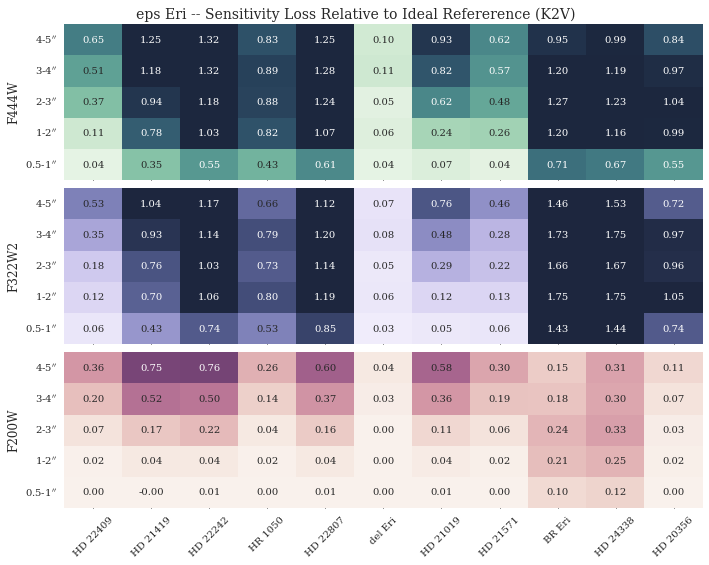

In [564]:
pp_epseri = PdfPages('eps_eri.pdf')

fig, axes = plt.subplots(3,1, sharex=True, figsize=(10,8))
hmap = mag_diff
map1 = hmap[::-1,1:][:nlims]
map2 = hmap[::-1,1:][nlims:2*nlims]
map3 = hmap[::-1,1:][2*nlims:3*nlims]

for i,ax in enumerate(axes):
    map_temp = hmap[::-1,1:][i*nlims:(i+1)*nlims]
    sns.heatmap(map_temp, ax=ax, vmin=0.01, vmax=1, cmap=cmap_list[i], cbar=False,
                annot=True, fmt='.2f', annot_kws={'fontsize':10})
    ax.set_ylabel(obs_params[::-1][i][0], fontsize=12)
    ylabels = ["{}-{}$^{{\prime\prime}}$".format(l1,l2) for l1,l2 in rlims]
    ax.set_yticklabels(ylabels, rotation=0)

#xlabels = ["{} ({})".format(tup[0], tup[1]) for tup in refs]
xlabels = names
ax.set_xticklabels(xlabels[1:], rotation=45)

fig.suptitle('eps Eri -- Sensitivity Loss Relative to Ideal Refererence (K2V)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05,top=0.95)

pp_epseri.savefig(figure=fig)

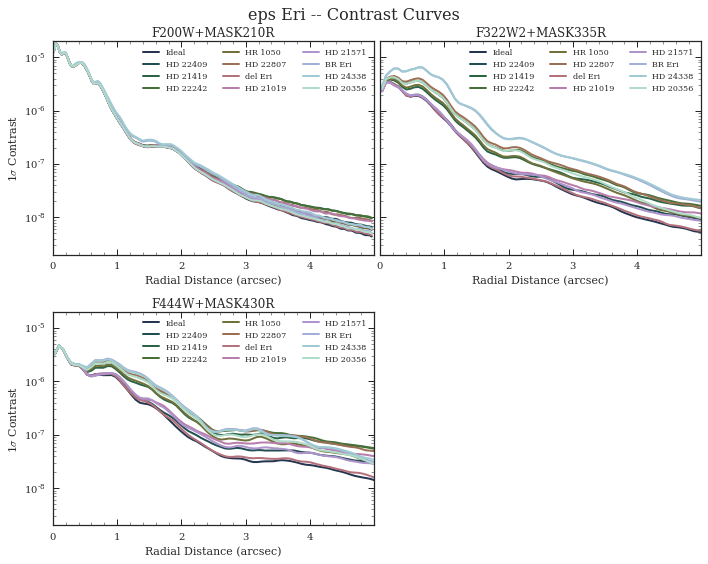

In [565]:
pal = sns.diverging_palette(220, 10, n=nref)
pal = sns.cubehelix_palette(nref, reverse=True)
pal = sns.color_palette("cubehelix", nref)
pal = sns.cubehelix_palette(nref, light=0.8, dark=0.2, reverse=True, start=1, rot=-2)

fig = plt.figure(figsize=(10,8))

for j, contrast_list in enumerate(contrast_eps_all):
    rr = rr_all[j]
    ax = fig.add_subplot(2,2,j+1)
    for i, contrast in enumerate(contrast_list):
        v0, v1, v2, v3, v4 = refs[i]
        #label = '{} ({})'.format(v0,v1)
        label = names[i]
        ax.semilogy(rr, contrast, color=pal[i], label=label, lw=2)

    ax.legend(ncol=3, fontsize=8)
    ax.set_xlim([0,4.99])
    ax.set_ylim([2e-9,2e-5])
    ax.set_xlabel('Radial Distance (arcsec)')
    if (j % 2) == 0: ax.set_ylabel('1$\sigma$ Contrast')
    else: ax.set_yticklabels('')
    
    filt, mask, pupil = obs_params[j]
    ax.set_title('{}+{}'.format(filt,mask), fontsize=12)
    
    ax.minorticks_on()

fig.suptitle('eps Eri -- Contrast Curves', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92, wspace=0.02)

pp_epseri.savefig(figure=fig)

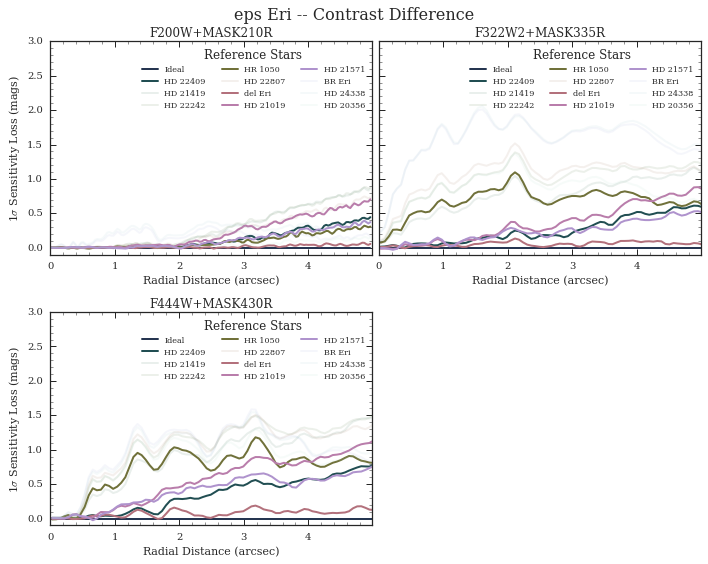

In [566]:
pal = sns.diverging_palette(220, 10, n=nref)
pal = sns.cubehelix_palette(nref, reverse=True)
pal = sns.color_palette("cubehelix", nref)
pal = sns.cubehelix_palette(nref, light=0.8, dark=0.2, reverse=True, start=1, rot=-2)

fig = plt.figure(figsize=(10,8))

best_names = ['Ideal', 'HD 22409', 'HR 1050', 'del Eri', 'HD 21571', 'HD 21019']

for j, contrast_list in enumerate(contrast_eps_all):
    contrast_ideal = contrast_eps_all[j][0]
    rr = rr_all[j]
    ax = fig.add_subplot(2,2,j+1)
    for i, contrast in enumerate(contrast_list):
        scale = contrast / contrast_ideal
        diff = 2.5*np.log10(scale)
        v0, v1, v2, v3, v4 = refs[i]
        alph=1 if v0 in best_names else 0.1
        #label = '{} ({})'.format(v0,v1)
        label = names[i]
        ax.plot(rr, diff, color=pal[i], label=label, lw=2, alpha=alph)

    ax.legend(ncol=3, fontsize=8, title='Reference Stars')
    ax.set_xlim([0,4.99])
    ax.set_ylim([-0.1,3])
    ax.set_xlabel('Radial Distance (arcsec)')
    if (j % 2) == 0: ax.set_ylabel('1$\sigma$ Sensitivity Loss (mags)')
    else: ax.set_yticklabels('')
    
    filt, mask, pupil = obs_params[j]
    ax.set_title('{}+{}'.format(filt,mask), fontsize=12)
    
    ax.minorticks_on()
    

fig.suptitle('eps Eri -- Contrast Difference', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92, wspace=0.02)

pp_epseri.savefig(figure=fig)
pp_epseri.close()

In [483]:
# Science Spectrum
bp_k = S.ObsBandpass('k')
sp_sci = pynrc.stellar_spectrum('A0V', 5, 'vegamag', bp_k, catname='ck04models')

# Science Image and planet PSF
psf0, psf0_over = sci.gen_psf(return_oversample=True, use_bg_psf=True) # Planet PSF
psf1, psf1_over = sci.gen_psf(sp_sci, return_oversample=True) # Science Target

9500 0.0 4.0


In [502]:
def calc_sigma(args):

    psf1, psf1_over, psf2, psf2_over = args

    # Detector-sampled difference
    scale = psf1.sum() / psf2.sum()
    psf_diff = psf1 - psf2*scale
    psf_diff_rot = rotate(psf_diff, 10, reshape=False)
    final = (psf_diff + psf_diff_rot) / 2

    hdu = fits.PrimaryHDU(final)
    hdu.header['EXTNAME'] = ('DET_SAMP')
    hdu.header['OVERSAMP'] = 1
    hdu.header['PIXELSCL'] = sci.pix_scale / hdu.header['OVERSAMP']
    hdu_diff = fits.HDUList([hdu])

    # Oversampled difference
    scale = psf1_over.sum() / psf2_over.sum()
    psf_diff = psf1_over - psf2_over * scale
    psf_diff_rot = rotate(psf_diff, 10, reshape=False)
    final = (psf_diff + psf_diff_rot) / 2

    hdu = fits.PrimaryHDU(final)
    hdu.header['EXTNAME'] = ('OVERSAMP')
    hdu.header['OVERSAMP'] = sci.psf_info['oversample']
    hdu.header['PIXELSCL'] = sci.pix_scale / hdu.header['OVERSAMP']
    hdu_diff.append(hdu)
    
    # Radially-averagd speckle noise
    binsize0 = hdu_diff[0].header['OVERSAMP'] * hdu_diff[0].header['PIXELSCL']
    binsize1 = hdu_diff[1].header['OVERSAMP'] * hdu_diff[1].header['PIXELSCL']
    rr0, stds0 = webbpsf.radial_profile(hdu_diff, ext=0, stddev=True, binsize=binsize0)
    rr1, stds1 = webbpsf.radial_profile(hdu_diff, ext=1, stddev=True, binsize=binsize1)

    # Ignore corner regions
    xsize = hdu_diff[0].header['PIXELSCL'] * hdu_diff[0].data.shape[0] / 2
    mask = rr1<xsize
    rr = rr1[mask]
    stds = stds1[mask]
    
    #bp = sci.bandpass
    #obs = S.Observation(sp_sci, bp, binset=bp.wave)

    #stds0 = nsig * stds0 / obs.countrate()
    #stds1 = nsig * stds1 / obs.countrate()

    #contrast0 = stds0 / psf0.max()
    #contrast1 = stds1 / psf0_over.max()
    
    return rr, stds

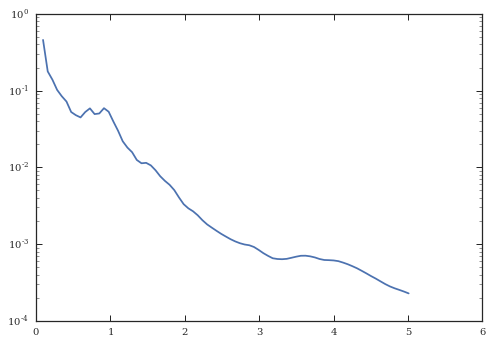

In [509]:
rr, stds = calc_sigma((psf1, psf1_over, psf2, psf2_over))
plt.semilogy(rr, stds)

In [535]:
hdu = fits.PrimaryHDU(psf1)
hdu.header['EXTNAME'] = ('DET_SAMP')
hdu.header['OVERSAMP'] = 1
hdu.header['PIXELSCL'] = sci.pix_scale / hdu.header['OVERSAMP']
hdulist = fits.HDUList([hdu])

# Oversampled difference
hdu = fits.PrimaryHDU(psf1_over)
hdu.header['EXTNAME'] = ('OVERSAMP')
hdu.header['OVERSAMP'] = sci.psf_info['oversample']
hdu.header['PIXELSCL'] = sci.pix_scale / hdu.header['OVERSAMP']
hdulist.append(hdu)


# Radially-averagd Poisson variance (per pixel)
binsize0 = hdulist[0].header['OVERSAMP'] * hdulist[0].header['PIXELSCL']
binsize1 = hdulist[1].header['OVERSAMP'] * hdulist[1].header['PIXELSCL']
rr0, avg0 = webbpsf.radial_profile(hdulist, ext=0, stddev=False, binsize=binsize0)
rr1, avg1 = webbpsf.radial_profile(hdulist, ext=1, stddev=False, binsize=binsize1)

# Ignore corner regions
xsize = hdulist[0].header['PIXELSCL'] * hdulist[0].data.shape[0] / 2
mask = rr1<xsize
rr1 = rr1[mask]
avg1 = avg1[mask]


pois_var0 = avg0 * hdulist[0].header['OVERSAMP']**2 / sci.multiaccum_times['t_exp']
pois_var1 = avg1 * hdulist[1].header['OVERSAMP']**2 / sci.multiaccum_times['t_exp']


In [536]:
fzodi = sci.bg_zodi()
det_ns = det.pixel_noise(fzodi=fzodi)

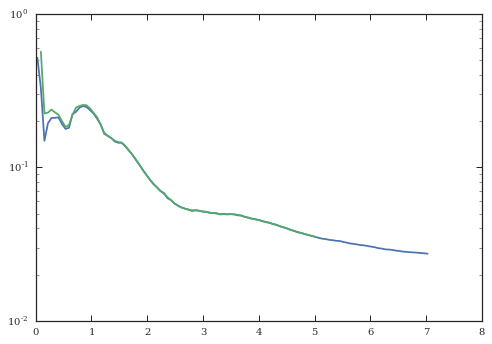

In [537]:
var0 = pois_var0 + det_ns**2
var1 = pois_var1 + det_ns**2 + stds**2
plt.semilogy(rr0, np.sqrt(var0))# / psf0.max() / obs.countrate())
plt.plot(rr1, np.sqrt(var1))# / psf0.max() / obs.countrate())

In [504]:
from copy import deepcopy
from scipy.ndimage.interpolation import rotate

bp = sci.bandpass
obs = S.Observation(sp_sci, bp, binset=bp.wave)


# Reference Spectrum
teff_arr = np.arange(3500,10000,500)#[::-1]
#teff_arr = [9500, 8500, 7500, 6500, 5500, 4500]
contrast_list = []
for teff in teff_arr:
    #teff = 9500
    print(teff)
    logg = 4.0 if teff >= 6500 else 4.5
    sp_ref = S.Icat('ck04models', teff, 0, logg)
    sp_ref = sp_ref.renorm(5, 'vegamag', bp_k)

    # Reference Image
    psf2, psf2_over = ref.gen_psf(sp_ref, return_oversample=True)
    
    args = (psf1, psf1_over, psf2, psf2_over)
    rr, stds = calc_sigma(args)
    
    nsig = 1
    stds = nsig * stds / obs.countrate()
    contrast = stds / psf0_over.max()
    
    contrast_list.append(contrast)


3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [496]:
len(teff_arr)

12

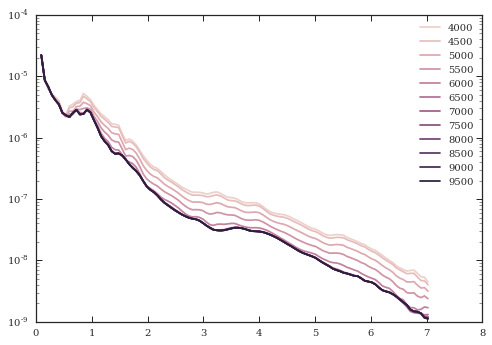

In [501]:
pal = sns.cubehelix_palette(len(teff_arr))
for i, contrast in enumerate(contrast_list):
    plt.semilogy(rr, contrast, label=teff_arr[i], color=pal[i])
    
plt.legend()

In [487]:
# N-sigma contrast
nsig = 1

rr0, stds0 = webbpsf.radial_profile(hdu_diff, ext=0, stddev=True)
rr1, stds1 = webbpsf.radial_profile(hdu_diff, ext=1, stddev=True, 
                                    binsize=hdu_diff[1].header['OVERSAMP']*hdu_diff[1].header['PIXELSCL'])

bp = sci.bandpass
obs = S.Observation(sp_sci, bp, binset=bp.wave)

stds0 = nsig * stds0 / obs.countrate()
stds1 = nsig * stds1 / obs.countrate()

contrast0 = stds0 / psf0.max()
contrast1 = stds1 / psf0_over.max()

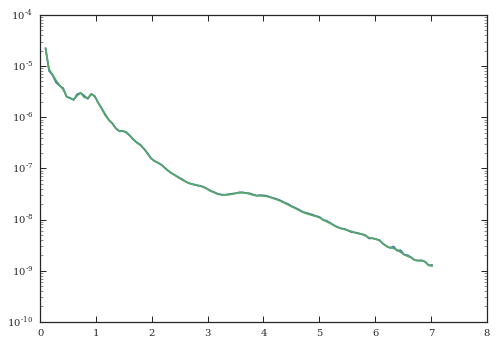

In [488]:
plt.semilogy(rr0, contrast0)
plt.semilogy(rr1, contrast1)
plt.ylim([1e-10,1e-4]);

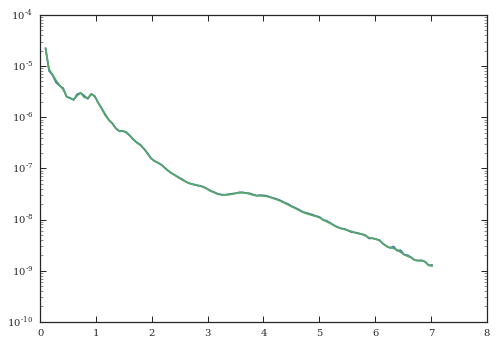

In [482]:
plt.semilogy(rr0, contrast0)
plt.semilogy(rr1, contrast1)
plt.ylim([1e-10,1e-4]);

In [29]:
# Science Spectrum
bp_k = S.ObsBandpass('k')
sp_sci = pynrc.stellar_spectrum('A0V', 5, 'vegamag', bp_k, catname='ck04models')

9500 0.0 4.0


In [125]:
im_slope[1].shape

(640, 640)

In [368]:
return_oversample = True

# Science Images
obs = sci
sp = sp_sci

# Slope images
oversample = obs.psf_info['oversample']
im_slope, im_slope_over = obs.gen_psf(sp, return_oversample=True)

# Noise image
zfact = 2.5
fzodi = obs.bg_zodi(zfact)
det = obs.Detectors[0]

if return_oversample:
    pix_var = det.pixel_noise(fzodi=fzodi)**2
    poisson_var = det.pixel_noise(fsrc=im_slope_over, fzodi=fzodi)**2 - pix_var
    im_var = poisson_var + pix_var / oversample**2
    im_noise = np.sqrt(im_var)
    im_slope = im_slope_over
else:
    im_noise = det.pixel_noise(fsrc=im_slope, fzodi=fzodi)

image_roll1 = im_slope + np.random.normal(scale=im_noise)
image_roll2 = im_slope + np.random.normal(scale=im_noise)

In [369]:
# Reference Spectrum
teff_arr = np.arange(4000,10100,100)[::-1]
#for teff in teff_arr:
teff = 6500
logg = 4.0 if teff >= 6500 else 4.5
sp_ref = S.Icat('ck04models', teff, 0, logg)
sp_ref = sp_ref.renorm(5, 'vegamag', bp_k)

In [370]:
# Reference Images
obs = ref
sp = sp_ref

# Slope image
oversample = obs.psf_info['oversample']
im_slope, im_slope_over = obs.gen_psf(sp, return_oversample=True)

# Noise image
zfact = 2.5
fzodi = obs.bg_zodi(zfact)
det = obs.Detectors[0]

if return_oversample:
    pix_var = det.pixel_noise(fzodi=fzodi)**2
    poisson_var = det.pixel_noise(fsrc=im_slope_over, fzodi=fzodi)**2 - pix_var
    im_var = poisson_var + pix_var / oversample**2
    im_noise = np.sqrt(im_var)
    im_slope = im_slope_over
else:
    im_noise = det.pixel_noise(fsrc=im_slope, fzodi=fzodi)

image_ref = im_slope + np.random.normal(scale=im_noise)


In [373]:
psf1, psf2 = sci.gen_psf(return_oversample=True, use_bg_psf=True)
psf_planet = psf2 if return_oversample else psf1

In [374]:
psf_planet.max()

0.00027832548851966597

-0.627985159801 1.32115897954


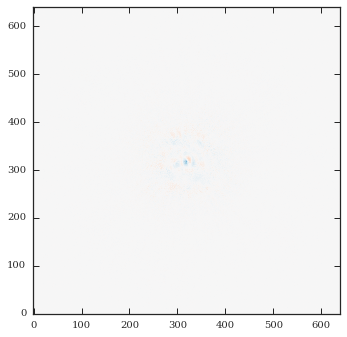

In [375]:
# Subtracted scaled reference image from each roll position
# Roll and average.

scale1 = image_roll1.sum() / image_ref.sum()
scale2 = image_roll2.sum() / image_ref.sum()

diff1 = image_roll1 - image_ref * scale1
diff2 = image_roll2 - image_ref * scale2
diff2_rot = scipy.ndimage.interpolation.rotate(diff2, 10, reshape=False)
final = (diff1 + diff2_rot) / 2
print(final.min(), final.max())

vmin, vmax = (-3,3)
plt.imshow(final, vmin=vmin, vmax=vmax, cmap='RdBu')

-6.98465659627 13.2736118565


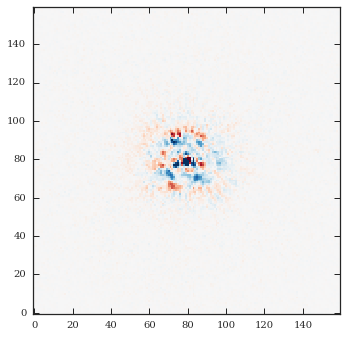

In [93]:
# Subtracted scaled reference image from each roll position
# Roll and average.

scale1 = image_roll1.sum() / image_ref.sum()
scale2 = image_roll2.sum() / image_ref.sum()

diff1 = image_roll1 - image_ref * scale1
diff2 = image_roll2 - image_ref * scale2
diff2_rot = scipy.ndimage.interpolation.rotate(diff2, 10, reshape=False)
final = (diff1 + diff2_rot) / 2
print(final.min(), final.max())

#vmin, vmax = (-3,3)
#plt.imshow(final, vmin=vmin, vmax=vmax, cmap='RdBu')

In [379]:
# Create an HDU list for WebbPSF tools
hdu = fits.PrimaryHDU(final)
hdu.header['OVERSAMP'] = oversample if return_oversample else 1
hdu.header['PIXELSCL'] = sci.pix_scale / hdu.header['OVERSMPL']
hdu.header['EXTNAME']  = ('FINAL')
hdulist = fits.HDUList([hdu])
rr, stds = webbpsf.radial_profile(hdulist, ext='FINAL', stddev=True)#, 
#                                  binsize=hdu.header['OVERSAMP']*hdu.header['PIXELSCL'])

# Ignore corner regions
xsize = hdulist['FINAL'].header['PIXELSCL'] * hdulist['FINAL'].data.shape[0] / 2
mask = rr<xsize
rr = rr[mask]
stds = stds[mask]

In [381]:
bp = sci.bandpass
obs = S.Observation(sp_sci, bp, binset=bp.wave)

# Normalized PSF radial standard deviation
nsig = 1
stds = nsig * stds / obs.countrate() / psf_planet.max()

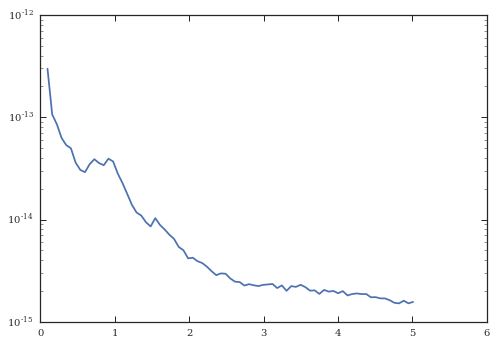

In [367]:
#rr2 = rr
#stds2 = stds

#contrast = stds / image_ref.max()
#sig_lim = 5 - 2.5*np.log10(contrast)
#plt.semilogy(rr, contrast)
plt.semilogy(rr, stds)


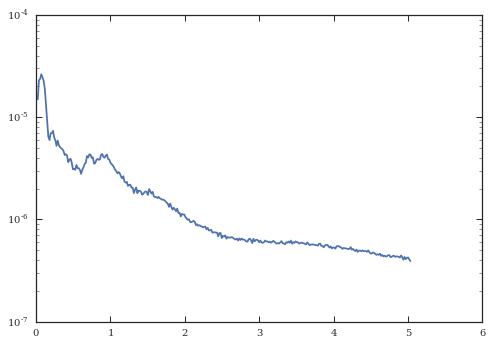

In [382]:
#rr2 = rr
#stds2 = stds

#contrast = stds / image_ref.max()
#sig_lim = 5 - 2.5*np.log10(contrast)
#plt.semilogy(rr, contrast)
plt.semilogy(rr, stds)
#plt.ylim([1e-10,1e-7])

In [115]:
star_mag = obs.effstim('vegamag')
sig_lim = star_mag - 2.5*np.log10(contrast)

sens_mag, _ = sci.sensitivity(units='vegamag', nsig=nsig, ideal_Poisson=True)
sig_lim_true = sens_mag['sensitivity']
print(star_mag, sig_lim_true)

5.00477352934 23.3152153582


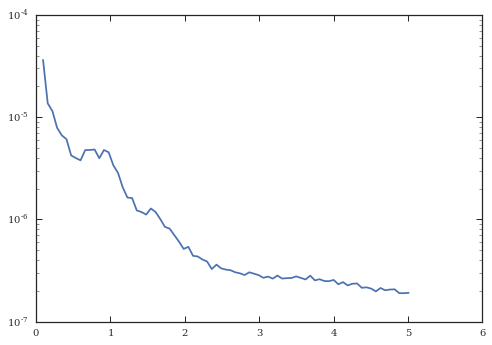

In [118]:
#rr2 = rr
#stds2 = stds

#contrast = stds / image_ref.max()
#sig_lim = 5 - 2.5*np.log10(contrast)
#plt.semilogy(rr, contrast)
plt.semilogy(rr, contrast)

In [14]:
bp_k = S.ObsBandpass('k')
sp_sci = pynrc.stellar_spectrum('A0V', 5, 'vegamag', bp_k, catname='ck04models')

teff = 6000
logg = 4.0 if teff >= 6500 else 4.5
sp_ref = S.Icat(catname, teff, 0, logg)

In [15]:
teff_arr

array([9900, 9800, 9700, 9600, 9500, 9400, 9300, 9200, 9100, 9000, 8900,
       8800, 8700, 8600, 8500, 8400, 8300, 8200, 8100, 8000, 7900, 7800,
       7700, 7600, 7500, 7400, 7300, 7200, 7100, 7000, 6900, 6800, 6700,
       6600, 6500, 6400, 6300, 6200, 6100, 6000, 5900, 5800, 5700, 5600,
       5500, 5400, 5300, 5200, 5100, 5000, 4900, 4800, 4700, 4600, 4500,
       4400, 4300, 4200, 4100, 4000])

In [6]:
bp_k = S.ObsBandpass('k')

f = fits.open('/Volumes/NIRData/IRTR_Spectral_Library/All_fits_091201/' + 'F4V_HD16232.fits')
hdu = f[0]
hdu.data.shape
mask = np.isfinite(hdu.data[1,:])
wave, flux, errf = hdu.data[:,mask]
sp = S.ArraySpectrum(wave, 0.1*flux, name='F4V', waveunits='um', fluxunits='flam')
sp.convert('Angstrom')
sp1 = sp.renorm(5, 'vegamag', bp_k, force=True)
f.close()

In [13]:
f = fits.open('/Volumes/NIRData/IRTR_Spectral_Library/All_fits_091201/' + 'F4III_HD21770.fits')
hdu = f[0]
hdu.data.shape
mask = np.isfinite(hdu.data[1,:])
wave, flux, errf = hdu.data[:,mask]
sp = S.ArraySpectrum(wave, 0.1*flux, name='F1V', waveunits='um', fluxunits='flam')
sp.convert('Angstrom')
sp2 = sp.renorm(5, 'vegamag', bp_k, force=True)
f.close()

In [14]:
sp_mod1 = pynrc.stellar_spectrum('F4III', 5, 'vegamag', bp_k)
sp_mod2 = pynrc.stellar_spectrum('F4III', 5, 'vegamag', bp_k, catname='ck04models')

7970 0.0 3.12
7970 0.0 3.12


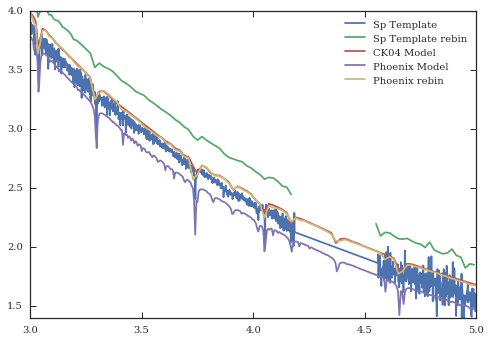

In [15]:
sp1.convert('um'); sp1.convert('Jy')
sp2.convert('um'); sp2.convert('Jy')
sp_mod1.convert('um'); sp_mod1.convert('Jy')
sp_mod2.convert('um'); sp_mod2.convert('Jy')

sp_mod3 = bin_spectrum(sp_mod1, sp_mod2.wave)
sp3 = bin_spectrum(sp2, sp_mod2.wave)

#plt.plot(sp1.wave, sp1.flux)
plt.plot(sp2.wave, sp2.flux, label='Sp Template')
plt.plot(sp3.wave, sp3.flux+0.3, label='Sp Template rebin')
plt.plot(sp_mod2.wave, sp_mod2.flux+0.2, label='CK04 Model')
plt.plot(sp_mod1.wave, sp_mod1.flux, label='Phoenix Model')
plt.plot(sp_mod3.wave, sp_mod3.flux+0.2, label='Phoenix rebin')
plt.xlim([3,5])
plt.ylim([1.4,4])

plt.legend()

In [8]:


bp_k = S.ObsBandpass('K')
sp_sci = pynrc.stellar_spectrum('A0V', 5, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum('A8V', 5, 'vegamag', bp_k)

9500 0.0 4.0
7650 0.0 4.0


In [169]:
psf_sci = sci.gen_psf(sp_sci)

In [100]:

psf_ref = sci.gen_psf(sp_ref)

scale = psf_sci.sum() / psf_ref.sum()
psf_ref *= scale

diff = psf_sci-psf_ref

In [99]:
print(scale, diff.max())

0.999043619982 3.97960052676


In [46]:
reload(nrc_utils)
reload(pynrc)

<module 'pynrc' from '/Users/jwstnircam/GitHub/pynrc/__init__.pyc'>

7250 0.0 4.0


(1.5, 3)

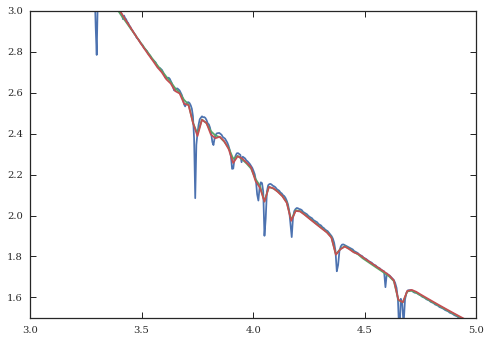

In [221]:

sp = pynrc.stellar_spectrum('F0V', 5, 'vegamag', sci.bandpass)
sp.convert('Jy')
sp.convert('um')
#plt.plot(sp.wave, sp.flux)

for mod in ['phoenix', 'ck04models', 'k93models']:
    sp = S.Icat(mod, 10000, 0, 4.0)
    sp = sp.renorm(5, 'vegamag', sci.bandpass)
    sp.convert('Jy')
    sp.convert('um')
    plt.plot(sp.wave, sp.flux)


plt.xlim([3,5])
plt.ylim([1.5,3])


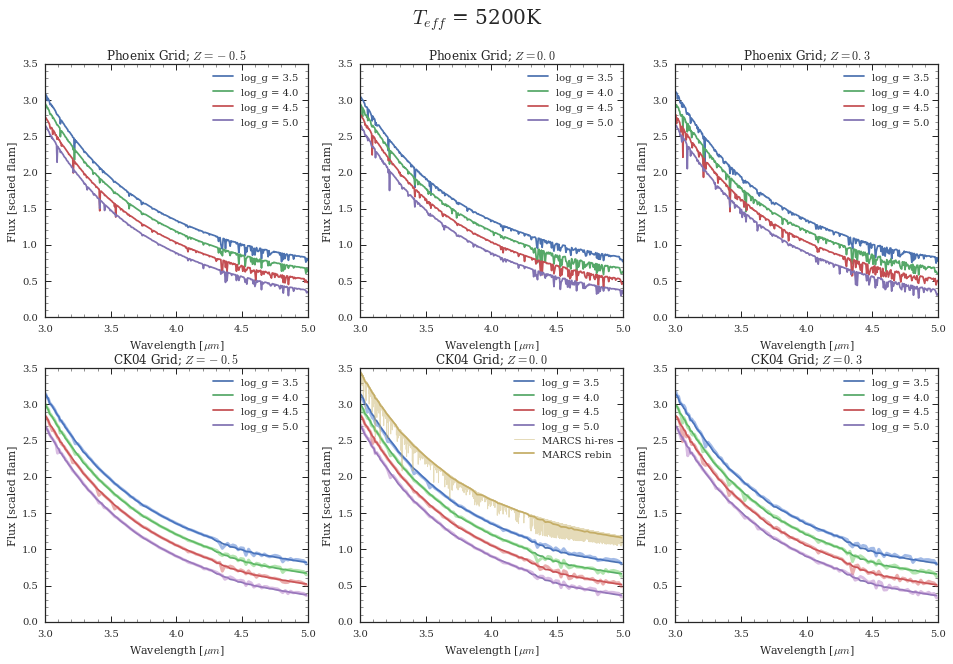

In [314]:
dir = '/Users/jwstnircam/NIRCam/cdbs.20.1rc1/grid/phoenix/'
zvals = ['m05', 'm00', 'p03']
zvals2 = [-0.5, 0.0, +0.3]

fig, axes = plt.subplots(2,3, figsize=(16,10))
axes = axes.flatten()

pal = sns.color_palette()
pal2 = sns.color_palette('muted')

t='5200'
for i, z in enumerate(zvals):
    ax = axes[i]
    
    file = '{0:}phoenix{1:}/phoenix{1:}_{2:}.fits'.format(dir,z,t)
    f = fits.open(file)
    w = f[1].data['WAVELENGTH'] / 1e4
    ind = (w>3) & (w<5)

    gvals = ['g35', 'g40', 'g45', 'g50']
    for j,g in enumerate(gvals):
        flux = f[1].data[g][ind]
        ax.plot(w[ind], flux/np.median(flux) + 0.15*(len(gvals)-j-1), 
                color=pal[j], label="log_g = {}.{}".format(g[1],g[2]))
        
    ax.set_title("Phoenix Grid; $Z={:.1f}$".format(zvals2[i]))
    f.close()
    
for i, z in enumerate(zvals2):
    gvals = [3.5, 4.0, 4.5, 5.0]
    ax = axes[i+3]
    for j,g in enumerate(gvals):
        sp = S.Icat('ck04models', int(t), z, g)
        w = sp.wave / 1e4; f = sp.flux
        ind = (w>3) & (w<5)
        flux = f[ind]
        ax.plot(w[ind], flux/np.median(flux) + 0.15*(len(gvals)-j-1), 
                color=pal[j], label="log_g = {}".format(g))
        
        # Downsample Phoenix model
        sp2 = S.Icat('phoenix', int(t), z, g)
        sp3 = bin_spectrum(sp2, sp.wave[ind], waveunits='angstrom')
        w = sp3.wave / 1e4; f = sp3.flux
        ind = (w>3) & (w<5)
        flux = f[ind]
        ax.plot(w[ind], flux/np.median(flux) + 0.15*(len(gvals)-j-1), 
                color=pal2[j], lw=3, alpha=0.5)
        
    ax.set_title("CK04 Grid; $Z={:.1f}$".format(z))

    

# Plot MARCS model
if '5200' in t:

    wave = ascii.read('temp_wave.txt', guess=False, format='basic', names=['Wave'], data_start=0)
    flux = ascii.read('temp_flux.txt', guess=False, format='basic', names=['Flux'], data_start=0)
    sp = S.ArraySpectrum(wave[0][:], flux[0][:], name='MySource')

    sp_temp = S.Icat('ck04models', int(t), z, g)
    ind = (sp_temp.wave>3e4) & (sp_temp.wave<5e4)

    sp2 = bin_spectrum(sp, sp_temp.wave[ind], waveunits='angstrom')

    w = sp.wave / 1e4; f = sp.flux
    ind = (w>3) & (w<5)
    flux = f[ind]
    scl = np.median(flux)
    axes[4].plot(w[ind], flux/scl + 0.8, color=pal[4], lw=1, alpha=0.5, label='MARCS hi-res')
    
    w = sp2.wave / 1e4; f = sp2.flux
    ind = (w>3) & (w<5)
    flux = f[ind]
    axes[4].plot(w[ind], flux/scl + 0.8, color=pal2[4], label='MARCS rebin')



for ax in axes:
    ax.set_ylabel('Flux [scaled flam]')
    ax.set_xlabel('Wavelength [$\mu m$]')
    ax.minorticks_on()
    ax.legend()



#fig.tight_layout()
fig.suptitle("$T_{{eff}}$ = {}K".format(t), fontsize=20)
fig.savefig('Models'+t+'K.pdf')

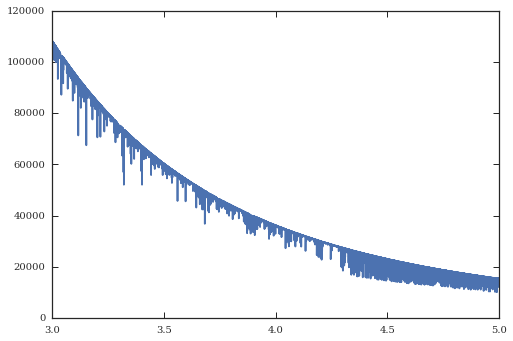

6000 0.0 4.5
6666 0.0 4.0
6833 0.0 4.0
7000 0.0 4.0
7125 0.0 4.0
7250 0.0 4.0
8250 0.0 4.0
9500 0.0 4.0


(1, 1000.0)

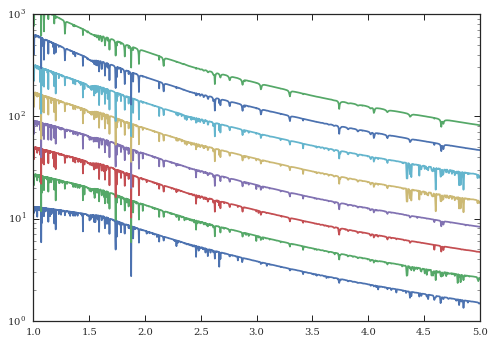

In [379]:
sp_list = ['A0V', 'A4V', 'F0V', 'F1V', 'F2V', 'F3V', 'F4V', 'G0V']#, 'M0V', 'K0III']


for i,spt in enumerate(sp_list[::-1]):
    sp = pynrc.stellar_spectrum(spt, 5, 'vegamag', bp_k)
    sp.convert('Jy')
    sp.convert('um')
    plt.semilogy(sp.wave, sp.flux*10**(i*0.25))

plt.xlim([1,5])
plt.ylim([1,1e3])

#sp = S.Icat('k93models', 7200, 0, 4.34)
#sp = sp.renorm(5, 'vegamag', bp_k)
#sp.convert('Jy')
#sp.convert('um')
#plt.plot(sp.wave, sp.flux*10**(10*0.25))

#sp_sci.convert('Jy')
#sp_ref.convert('Jy')

#plt.semilogy(sp_sci.wave/1e4, sp_sci.flux)
#plt.plot(sp_ref.wave/1e4, sp_ref.flux)


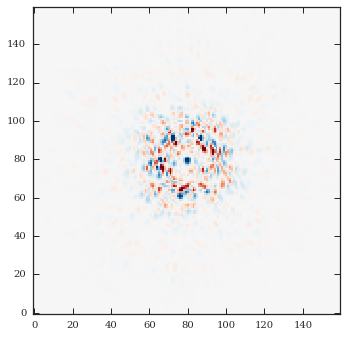

In [95]:
plt.imshow(diff, vmin=-1, vmax=1, cmap='RdBu')

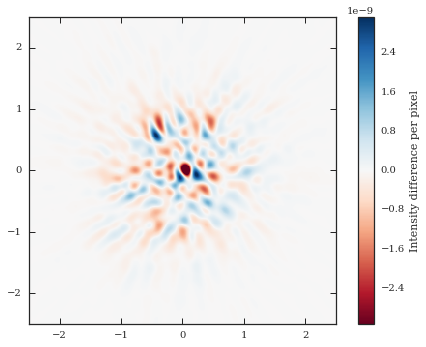

In [99]:
hdu1 = psf_star1
hdu2 = psf_ref1
vlim = 5e-8
ext = 0
if ext==0: vlim = vlim/16

webbpsf.display_psf_difference(hdu1,hdu2,ext,ext, -vlim,vlim, title='', imagecrop=5, cmap='RdBu')

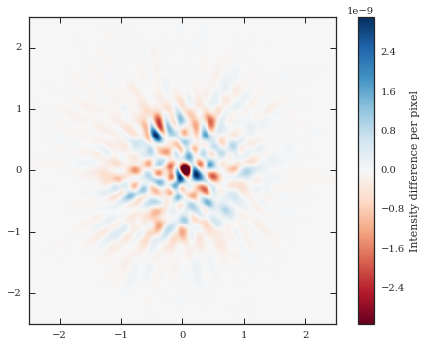

In [101]:
hdu2 = psf_star2
hdu1 = psf_ref2
vlim = 5e-8
ext = 0
if ext==0: vlim = vlim/16

webbpsf.display_psf_difference(hdu1,hdu2,ext,ext, -vlim,vlim, title='', imagecrop=5, cmap='RdBu')

In [104]:
hdu1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  636                                                  
NAXIS2  =                  636                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 4.36053339409786E-06 / Weighted mean wavelength in meters             
DIFFLMT =   0.1223021480547469 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=              0.01575 / Scale in arcsec/pix (after oversampling)       
FOV     =               10.0